In [11]:
%matplotlib inline

In [12]:
import os
import pickle
import sys
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import combinations
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
from joblib import Parallel, delayed
from matplotlib import colors
from networkx.algorithms.community.quality import modularity as nx_modularity
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils.testing import ignore_warnings
from tqdm.notebook import tqdm


sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

# Functions

In [13]:
def create_krondecker(partition):
    n = len(partition)
    kron_mask = np.tile(partition, n) == np.repeat(partition, n)
    return np.reshape(kron_mask, (n, n))

def modularity2(AIJ, partition):
    n = len(AIJ)
    m = np.sum(AIJ)  # no of edges

    k = np.sum(AIJ, axis=1)
    expectation = np.reshape(np.tile(k, n) * np.repeat(k, n), (n, n)) / m
    kron = create_krondecker(partition)

    # Q = (1 / 2m) * SUM(AIJ - (ki.kj / 2m)) ∂(ci, cj)
    return (1.0 / m) * np.sum(kron * (AIJ - expectation))

In [14]:
def np2nx(A: np.ndarray, partition: np.ndarray):
    G = nx.from_numpy_matrix(A)
    nx.set_node_attributes(G, dict(enumerate(partition)), 'community')
    return G

def partition2communities(partition):
    result = defaultdict(list)
    for idx, class_ in enumerate(partition):
        result[class_].append(idx)
    return list(result.values())

def estimate_mu(graph, partition):
    n_out_edges = 0
    n_nodes = graph.size()
    for n1, n2 in graph.edges():  # links:
        if partition[n1] != partition[n2]:
            n_out_edges += 1
    return n_out_edges / n_nodes

def power_law(values, maxval=200):
    tau = powerlaw.Fit(values, verbose=False).alpha
    if tau > maxval or np.isnan(tau):
        tau = maxval
    return tau

def redetect_params(data):
    A, partition = data['A'], data['y_true']
    G = np2nx(A, partition)
    
    n = G.number_of_nodes()
    average_degree = 2 * G.number_of_edges() / n
    node_degrees = [d for n, d in G.degree()]
    min_degree = np.min(node_degrees)
    max_degree = np.max(node_degrees)
    tau1 = power_law(node_degrees, 250)
    modularity = nx_modularity(G, partition2communities(partition))

    # Community-based parameters
    k = len(set(partition))
    mu = min(max(estimate_mu(G, partition), 0.), 1.)
    community_sizes = list(Counter(partition).values())
    min_community = np.min(community_sizes)
    max_community = np.max(community_sizes)
    tau2 = power_law(community_sizes, 250)
    
    return {
        'n': n,
        'k': k,
        'average_degree': average_degree,
        'min_degree': min_degree, 
        'max_degree': max_degree,
        'tau1': tau1,
        'mu': mu,
        'min_community': min_community,
        'max_community': max_community,
        'tau2': tau2,
        'modularity': modularity
    }

In [15]:
def point2plot(x, feature_name):
    vmin, vmax = limits[feature_name]
    return (x - vmin) / (vmax - vmin) * resolution

In [16]:
class RFE:
    def __init__(self, estimator, names, max_features=5, n_jobs=None):
        self.estimator = estimator
        self.names = names
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.results = {}

    @ignore_warnings(category=ConvergenceWarning)
    def score_one(self, x, y, weights, set_feat_names):
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)

        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        if np.max(y) == 1:
            y_pred = estimator.predict_proba(x[:, support])
            y_pred = y_pred[:, 1] > 0.5
        else:
            y_pred = estimator.predict(x[:, support])
        f1 = f1_score(y, y_pred)
        return set_feat_names, f1, estimator

    def fit(self, x, y, weights):
        # for all features first:
        _, f1_all, estimator_all = self.score_one(x, y, weights, self.names)
        print(f'all features, f1={f1_all:.3f}')

        for n_features in range(1, self.max_features + 1):
            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self.score_one)(x, y, weights, set_feat_names)
                for set_feat_names in list(combinations(self.names, n_features)))
            best_n_feat, best_f1, best_estimator = None, 0, None
            for set_feat_names, f1, estimator in results:
                if f1 > best_f1:
                    best_n_feat, best_f1, best_estimator = set_feat_names, f1, estimator
            print(f'{n_features} features, f1={best_f1:.3f}, set={best_n_feat}')
            if hasattr(best_estimator, 'best_params_'):
                print(best_estimator.best_params_)
            self.results[n_features] = {
                'f1': best_f1,
                'set': best_n_feat
            }
        return self

# Prepare data

In [17]:
import datetime
print(datetime.datetime.now())

2020-09-10 15:53:14.749429


In [18]:
resolution = 100

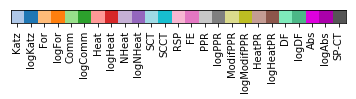

In [19]:
a = np.zeros((1, 25, 3), dtype=np.uint8)
labels = []
for idx, kernel in enumerate(kernels):
    a[0, idx] = np.array(colors.to_rgb(d3_colors[kernel.name])) * 255
    labels.append(kernel.name)
plt.imshow(a)
plt.xticks(range(25), labels, rotation='vertical')
plt.yticks([]);

In [20]:
root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr'
    
def perform_one(fn):
    with open(f'{root}/{fn}', 'rb') as f:
        data = pickle.load(f)
    need_to_save = False
    A = data['A']
    item = {}
    for kernel_name, kernel_results in data['results'].items():
        kernel_best_ari = -1
        for parameter, parameter_results in kernel_results.items():
            if len(parameter_results) > 0:
                if 'new_modularity2' not in parameter_results[0]:  # add new_modularity if not exist
                    for init_idx, init in enumerate(parameter_results):
                        partition = init['labels']
                        init['new_modularity2'] = modularity2(A, partition)
                    need_to_save = True
                param_best_ari = sorted(parameter_results, key=lambda x: -x['new_modularity2'])[0]['score_ari']
                kernel_best_ari = max(kernel_best_ari, param_best_ari)
        item[kernel_name] = kernel_best_ari
    
    if need_to_save:
        with open(f'{root}/{fn}', 'wb') as f:
            pickle.dump(data, f)
    
    return item, redetect_params(data)

dataset = Parallel(n_jobs=12)(delayed(perform_one)(fn) for fn in tqdm(os.listdir(root)))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [23]:
# generate additional features
for item in dataset:
    maxari = np.max(list(item[0].values()))
    item[1]['maxari'] = maxari
    item[1]['average_degree/n'] = item[1]['average_degree'] / item[1]['n']
    item[1]['min_community/max_community'] = item[1]['min_community'] / item[1]['max_community']
    item[1]['min_degree/max_degree'] = item[1]['min_degree'] / item[1]['max_degree']
    item[1]['mu/(average_degree/n)'] = item[1]['mu'] / (item[1]['average_degree'] / item[1]['n'])

In [24]:
all_feature_names = [
    'n',
    'k',
    'tau1',
    'tau2',
    'mu',
    'average_degree',
    'min_community',
    'maxari',
    'modularity',
    'average_degree/n',
    'min_community/max_community',
    'min_degree/max_degree',
    'mu/(average_degree/n)'
]

fnc = {
    'n': lambda x: x/1500,
    'k': lambda x: ((1 - 1/x) - 0.5) * 2,
    'tau1': lambda x: 1 - (1 / x**0.5),
    'tau2': lambda x: 1 - (1 / x**0.5),
    'mu': lambda x: x,
    'average_degree': lambda x: x/850,
    'min_community': lambda x: x/750,
    'maxari': lambda x: x,
    'modularity': lambda x: (x + 0.5) * 0.75,
    'average_degree/n': lambda x: x / 0.7,
    'min_community/max_community': lambda x: x,
    'min_degree/max_degree': lambda x: x / 0.7,
    'mu/(average_degree/n)': lambda x: x ** 0.25 / 4
}

In [25]:
real_limits = {}
limits = {}
for fname in all_feature_names:
    min_max = np.min([info[fname] for _, info in dataset]), np.max([info[fname] for _, info in dataset])
    real_limits[fname] = min_max
    limits[fname] = fnc[fname](min_max[0]), fnc[fname](min_max[1])
    print(f'{fname}: {real_limits[fname][0]:.2f}, {real_limits[fname][1]:.2f} | {limits[fname][0]:.2f}, {limits[fname][1]:.2f}')

n: 10.00, 1499.00 | 0.01, 1.00
k: 2.00, 224.00 | 0.00, 0.99
tau1: 1.87, 235.90 | 0.27, 0.93
tau2: 1.51, 250.00 | 0.19, 0.94
mu: 0.00, 1.00 | 0.00, 1.00
average_degree: 1.17, 954.59 | 0.00, 1.12
min_community: 1.00, 749.00 | 0.00, 1.00
maxari: 0.00, 1.00 | 0.00, 1.00
modularity: -0.50, 0.95 | -0.00, 1.09
average_degree/n: 0.00, 0.80 | 0.00, 1.15
min_community/max_community: 0.01, 1.00 | 0.01, 1.00
min_degree/max_degree: 0.00, 0.86 | 0.00, 1.23
mu/(average_degree/n): 0.00, 368.32 | 0.05, 1.10


In [26]:
kernels_order = [x.name for x in kernels]
list(enumerate(kernels_order))

[(0, 'Katz'),
 (1, 'logKatz'),
 (2, 'For'),
 (3, 'logFor'),
 (4, 'Comm'),
 (5, 'logComm'),
 (6, 'Heat'),
 (7, 'logHeat'),
 (8, 'NHeat'),
 (9, 'logNHeat'),
 (10, 'SCT'),
 (11, 'SCCT'),
 (12, 'RSP'),
 (13, 'FE'),
 (14, 'PPR'),
 (15, 'logPPR'),
 (16, 'ModifPPR'),
 (17, 'logModifPPR'),
 (18, 'HeatPR'),
 (19, 'logHeatPR'),
 (20, 'DF'),
 (21, 'logDF'),
 (22, 'Abs'),
 (23, 'logAbs'),
 (24, 'SP-CT')]

# Search for best basis

In [79]:
class SBM_GridSearch:
    def __init__(self, tx, ty):
        self.tx = tx
        self.ty = ty
        self.Cs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
        self.pos_gammas = [1] #[0.5, 1, 2, 5, 10, 100]
        self.neg_gammas = [0.5, 1, 2, 5, 7, 10]

    def run_one(self, C, weights, ty_bool):
        y_pred = SVC(C=C, probability=True).fit(self.tx, ty_bool).predict_proba(self.tx)[:, 1]
        f1 = f1_score(ty_bool, y_pred > 0.5)
        return f1

    def best_set(self, kernel_name):
        measure_idx = kernels_order.index(kernel_name)
        ari_measure = self.ty[:, measure_idx]
        ari_other = np.max(np.concatenate((self.ty[:, :measure_idx], self.ty[:, measure_idx+1:]), axis=1), axis=1)
        ty_bool = ari_measure >= ari_other
        print(f'{kernel_name} ({measure_idx}), {np.sum(ty_bool)}')

        best_f1, best_C, best_pos_gamma, best_neg_gamma = 0, 0, 0, 0
        if np.sum(ty_bool) > 0:
            for C in self.Cs:
                for pos_gamma in self.pos_gammas:
                    for neg_gamma in self.neg_gammas:
                        win_weights = 1 / np.sum(self.ty == np.max(self.ty, axis=1, keepdims=True), axis=1)**pos_gamma
                        lose_weights = np.clip(np.abs(ari_measure - ari_other) * neg_gamma, 0, 1)
                        weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

                        f1 = self.run_one(C, weights, ty_bool)
                        if f1 > best_f1:
                            best_f1, best_C, best_pos_gamma, best_neg_gamma = f1, C, pos_gamma, neg_gamma

                f1 = self.run_one(C, None, ty_bool)
                if f1 > best_f1:
                    best_f1, best_C, best_pos_gamma, best_neg_gamma = f1, C, None, None

        return {
            'f1': best_f1,
            'C': best_C,
            'pos_gamma': best_pos_gamma,
            'neg_gamma': best_neg_gamma
        }

In [80]:
all_feature_names = [
    'n',
#     'k',
    'tau1',
    'tau2',
    'mu',
    'average_degree',
#     'min_community',
    'maxari',
    'modularity',
    'average_degree/n',
#     'min_community/max_community',
#     'min_degree/max_degree',
#     'mu/(average_degree/n)'
]

In [81]:
combs = []
for i in range(1, len(all_feature_names)+1):
    combs.extend([list(x) for x in combinations(all_feature_names, i)])
print(len(combs))

255


In [84]:
def one(comb):
    print(comb)
    
    tx = np.array([[fnc[fname](item[1][fname]) for fname in comb] for item in dataset]).astype(np.float32)
    ty = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset]).astype(np.float32)
    print(tx.shape, ty.shape)

    tx = tx[np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1) < 2]
    ty = ty[np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1) < 2]
    print(tx.shape, ty.shape)
    
    results_wscct = {}
    gs = SBM_GridSearch(tx, ty)
    for kernel_name in kernels_order:
        res = gs.best_set(kernel_name)
        print(f"{res['f1']:.3f}, {res['C']:.3f}, {res['pos_gamma']}, {res['neg_gamma']}")
        results_wscct[kernel_name] = res
        
        
    tywo11 = ty.copy()
    tywo11[:, 11] = 0
    
    results_woscct = {}
    gs = SBM_GridSearch(tx, tywo11)
    for kernel_name in kernels_order:
        results_woscct[kernel_name] = gs.best_set(kernel_name)
  
    return comb, results_wscct, results_woscct
    
results = Parallel(n_jobs=12)(delayed(one)(comb) for comb in tqdm(combs))

In [98]:
ty = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset]).astype(np.float32)
ty = ty[np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1) < 2]
tywo11 = ty.copy()
tywo11[:, 11] = 0
ty = np.argmax(ty, axis=1)
tywo11 = np.argmax(tywo11, axis=1)
for idx, kernel_name in enumerate(kernels_order):
    print(f'{kernel_name} ({np.sum(ty == idx)})', end='\t')
print()
for idx, kernel_name in enumerate(kernels_order):
    print(f'{kernel_name} ({np.sum(tywo11 == idx)})', end='\t')

Katz (15)	logKatz (26)	For (3)	logFor (8)	Comm (78)	logComm (77)	Heat (12)	logHeat (12)	NHeat (221)	logNHeat (2)	SCT (52)	SCCT (784)	RSP (51)	FE (9)	PPR (5)	logPPR (11)	ModifPPR (1)	logModifPPR (10)	HeatPR (5)	logHeatPR (4)	DF (15)	logDF (32)	Abs (20)	logAbs (2)	SP-CT (31)	
Katz (81)	logKatz (45)	For (5)	logFor (10)	Comm (114)	logComm (102)	Heat (20)	logHeat (17)	NHeat (490)	logNHeat (23)	SCT (124)	SCCT (0)	RSP (135)	FE (26)	PPR (5)	logPPR (28)	ModifPPR (1)	logModifPPR (23)	HeatPR (6)	logHeatPR (5)	DF (22)	logDF (42)	Abs (45)	logAbs (9)	SP-CT (108)	

In [90]:
for comb, rw, rwo in results:
    print(comb, end='\t')
    for kernel_name in kernels_order:
        print(rwo[kernel_name]['f1'], end='\t')
    print()

['n']	0.07484407484407483	0.08421052631578947	0.005102040816326531	0.02006688963210702	0	0.13410404624277455	0.03488372093023255	0.03012048192771084	0	0.05882352941176471	0.1226215644820296	0	0.19036697247706422	0.033268101761252444	0	0.034447821681864235	0	0.03389830508474576	0.020833333333333336	0.04975124378109452	0.10416666666666666	0.03773584905660377	0.08912188728702491	0.05263157894736842	0.14074074074074075	
['tau1']	0.11264822134387352	0.054309327036599755	0	0	0.09343715239154617	0.1616161616161616	0.04819277108433734	0.038834951456310676	0.15114235500878737	0.04291845493562232	0.14404432132963987	0	0.14964028776978416	0.03460207612456747	0.026548672566371688	0.037833190025795355	0.012738853503184714	0.0425531914893617	0.012195121951219513	0.03773584905660377	0.0875	0.10476190476190475	0.058519793459552494	0	0.04268292682926829	
['tau2']	0.10336341263330599	0.06802721088435373	0.01680672268907563	0.02783300198807157	0	0.14153846153846153	0.10526315789473685	0.05333333333333334

In [ ]:
for mari, sigma, comb in results:
    print(f'{mari:.4f}\t{sigma:.3f}\t{comb}')